# Squared Loss Diversity Experiments

This notebook produces the Figure 8 from Section 4 of https://arxiv.org/abs/2301.03962v1


## Comparing Bagging and Random Forests

In [1]:
## Necessary imports and checks
import matplotlib.pyplot as plt
%matplotlib inline

import os
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import  BaggingRegressor, RandomForestRegressor
from decompose.data_utils import load_standard_dataset
from decompose import BVDExperiment
from decompose.plotting_utils import plot_bvd

# Make sure imagees and data directories exist for results/plots
if not os.path.exists("images"):
    os.mkdir("images")
if not os.path.exists("data"):
    os.mkdir("data")
if not os.path.exists("logs"):
    os.mkdir("logs")




### Setting Up Variables

In [2]:
# Setting up data
np.random.seed(0)
DATASET_NAME = "california"
train_data, train_labels, test_data, test_labels = load_standard_dataset(DATASET_NAME, 0.5,
                                                                         normalize_data=True)
N_TRIALS = 100

# Setting up models
results_objects = {}

bagging = BaggingRegressor(base_estimator=DecisionTreeRegressor(),
                           n_estimators=10,
                           warm_start=False)

models = {
          "Bagging": bagging,
          }

### Training the Models

In [3]:
for name, model in models.items():
    np.random.seed(0)
    # Create experiment object and define parameter to vary
    experiment = BVDExperiment(model,
                               "squared",
                               parameter_name="max_depth",
                               parameter_values=range(1,11,1),
                               )
    # Run experiment on data
    results = experiment.run_experiment(train_data, train_labels, test_data, test_labels, n_trials=N_TRIALS, n_test_splits=1)
    results_objects[name] = results
    results.save_results(f"data/squared_decomp_depth_{name}_{DATASET_NAME}_results_{N_TRIALS}.pkl")

100%|██████████| 10/10 [04:32<00:00, 27.22s/it]



## Plotting Results

### Figure 7: Breakdown of Expected Risk into Bias, Variance and Diversity in Bagged Regression Trees

In [6]:
from decompose.experiments import load_results


# load results objects into dictionary where key is model name
results_objects = {}
for name in models:
    results_objects[name] = load_results(f"data/squared_decomp_depth_{name}_{DATASET_NAME}_results_{N_TRIALS}.pkl")
    

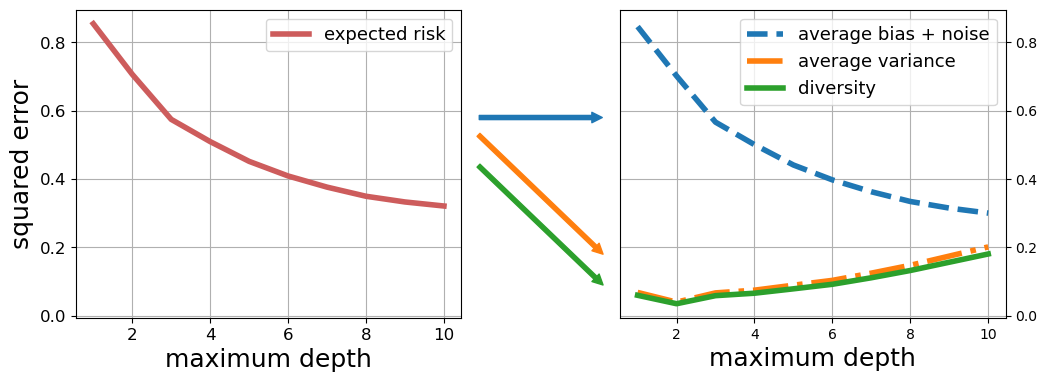

In [7]:
import matplotlib.patches as mpatches

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4), gridspec_kw={"width_ratios": [3, 1, 3]})


plt.subplots_adjust(wspace=0.05, hspace=0)


arrow = mpatches.FancyArrowPatch((0.0, 0.65),(1.0, 0.65), # ((x tail, y tail), (x head, y head))
                                 mutation_scale=15,
                                 transform=axes[1].transAxes, color="tab:blue")
arrow2 = mpatches.FancyArrowPatch((0.0, 0.6), (1.0, 0.2), # ((x tail, y tail), (x head, y head))
                                 mutation_scale=15,
                                 transform=axes[1].transAxes,
                                 color="tab:orange")
arrow3 = mpatches.FancyArrowPatch((0.0, 0.5),(1.0, 0.1),  # ((x tail, y tail), (x head, y head))
                                 mutation_scale=15,
                                 transform=axes[1].transAxes,
                                 color="tab:green")

axes[1].axis("off")
axes[1].add_patch(arrow)
axes[1].add_patch(arrow2)
axes[1].add_patch(arrow3)
plot_bvd(results_objects["Bagging"], bias=False, variance=False, diversity=False, axes=axes[0])
plot_bvd(results_objects["Bagging"], ensemble_risk=False, axes=axes[2])
axes[0].set_xlabel("maximum depth", size=18)
axes[2].set_xlabel("maximum depth", size=18)
axes[2].yaxis.tick_right()
axes[2].legend(prop={"size":13})
axes[0].legend(prop={"size":13})
axes[0].tick_params(axis="both", labelsize= 12)
#axes[2].yaxis.set_label_position("right")
axes[2].tick_params(labelleft=False, labelright=True)
axes[0].set_ylabel("squared error", size=18)

FIGURE_NAME = f"images/error_and_bv_depth_{DATASET_NAME}_{N_TRIALS}.pdf"
plt.savefig(FIGURE_NAME, bbox_inches="tight")